In [1]:
import pandas as pd
import numpy as np
import datetime as dt
import os, json
import matplotlib.pyplot as plt 
%matplotlib inline 
import seaborn as sns

In [2]:
#func that reads the ''category'' column (from JSON format)
def CustomParser1(df):
    j1 = json.loads(df)
    return j1

In [3]:
df=pd.read_csv('Data/Kickstarter.csv',converters={'category':CustomParser1},header=0)
#make differnt columns out of ''category'' format
df[sorted(df['category'][0].keys(),reverse=False)] = df['category'].apply(pd.Series) 
df1=df[['category','color','parent_id','urls','id','name','position']]
df['category.parent_id']=df1['position']
df['category.id']=df1['color']
df['category.position']=df1['parent_id']
df['category.name']=df1['id']
df['category.slug']=df1['name']
#split ''slug'' and leaves just the main category name
df['category.slug']=df['category.slug'].apply(lambda x: x.split('/'))
df['category.slug']=df['category.slug'].apply(lambda x: x.pop(0))
df[['category','category.parent_id','category.id','category.name','category.position','category.slug']][:1]
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3813 entries, 0 to 3812
Data columns (total 45 columns):
backers_count               3813 non-null int64
blurb                       3813 non-null object
category                    3813 non-null object
converted_pledged_amount    3813 non-null int64
country                     3813 non-null object
created_at                  3813 non-null int64
creator                     3813 non-null object
currency                    3813 non-null object
currency_symbol             3813 non-null object
currency_trailing_code      3813 non-null bool
current_currency            3813 non-null object
deadline                    3813 non-null int64
disable_communication       3813 non-null bool
friends                     0 non-null float64
fx_rate                     3813 non-null float64
goal                        3813 non-null float64
id                          3813 non-null object
is_backing                  0 non-null float64
is_starrable         

In [4]:
# func that reads the ''creator'' column (from JSON format).
#some of the cells cause problems 
    #for exemple- the cell JSON format include double apostrophes in nicknames like "Elad "Superman" Toister" confused it.

def CustomParser2(df2):
    try:
        j2 = json.loads(df2)
        return j2
    except: #the func pass all the errored rows and return 0 to the "creator" columnn. 
        return 0
    pass
            
df2=pd.read_csv('Data/Kickstarter.csv',converters={'creator':CustomParser2},header=0)
#count and collect all the droped rows- so we can know the "cost" of te dropping (and maybe i will succed to solve it in the future)
droped=df2.loc[df2['creator']==0,['creator']]
df2=df2.loc[df2['creator']!=0]
drop_list=list(droped.index)
#df['creator'].iloc[drop_list]=df['creator'].iloc[drop_list].apply(lambda x: x.replace(' ',',')) is a start of a solution
df=df.drop(index=drop_list)
print('droped rows:',len(drop_list),drop_list)
print (len(df))
print (len(df2))


droped rows: 3 [587, 1661, 1968]
3810
3810


In [5]:
# 2 func that make diffent columns out of "creator" column (the auto func i used before don't works here. i did it manually)
df2['creator_name']=df2['creator'].apply(lambda x: x['name'])
df2['creator_id']=df2['creator'].apply(lambda x: x['id'])
#"inject" it back to the original df
df['creator_name']=df2['creator_name']
df['creator_id']=df2['creator_id']
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3810 entries, 0 to 3812
Data columns (total 47 columns):
backers_count               3810 non-null int64
blurb                       3810 non-null object
category                    3810 non-null object
converted_pledged_amount    3810 non-null int64
country                     3810 non-null object
created_at                  3810 non-null int64
creator                     3810 non-null object
currency                    3810 non-null object
currency_symbol             3810 non-null object
currency_trailing_code      3810 non-null bool
current_currency            3810 non-null object
deadline                    3810 non-null int64
disable_communication       3810 non-null bool
friends                     0 non-null float64
fx_rate                     3810 non-null float64
goal                        3810 non-null float64
id                          3810 non-null object
is_backing                  0 non-null float64
is_starrable         

In [6]:
#cleaning func
def clean(df):
    data = df.copy()
    #this is important beacuse this is the part we dicided  which columns entered the data set.
    #the main structure is like in the exemple but i manipulate and add some additional columns i think we need to include(*marked) . 
    selected_cols = ['creator_name', #*
                     'creator_id', #*
                     'backers_count',
                     'blurb',
                     'is_starred', #*
                     'category.id', #*
                     'category.name',
                     'category.parent_id',
                     'category.slug',
                     'country',
                     'created_at',
                     'currency',  
                     'deadline',
                     'goal',
                     'launched_at',
                     'spotlight',
                     'staff_pick',
                     'state',
                     'usd_pledged',
                     'usd_type']
    data = data[selected_cols]
    data['is_starred']=data['is_starred'].replace({1: True , None: False})
    data = data.dropna()
    successful = data['state'] == "successful"
    failed = data['state'] == "failed"
    cancelled = data['state'] == "cancelled"
    suspended = data['state'] == "suspended"
    data = data.loc[failed | successful | cancelled | suspended]
    num_cols = ['usd_pledged',
                'deadline',
                'created_at',
                'launched_at']
    data[num_cols] = data[num_cols].apply(pd.to_numeric, errors='coerce')
    data['created_at'] = pd.to_datetime(data['created_at'],unit='s')
    data['launched_at'] = pd.to_datetime(data['launched_at'],unit='s')
    data['deadline'] = pd.to_datetime(data['deadline'],unit='s')
    return data

data = clean(df)


In [7]:
def engineer_features(data):
    #make state 1 or 0
    data['state'].replace('suspended','failed',inplace=True)   
    data['state_num'] = data['state'].apply(lambda x: 1 if x=='successful' else 0)
    #time to reletive time
    data['launched_at_hr'] = data['launched_at'].apply(lambda x: x.hour) + 1
    data['launched_at_day_in_week'] = data['launched_at'].apply(lambda x: x.dayofweek + 1)
    data['launched_at_day_in_month'] = data['launched_at'].apply(lambda x: x.day ) #Elad's comment
    data['launched_at_mo'] = data['launched_at'].apply(lambda x: x.month)
    data['launched_at_yr'] = data['launched_at'].apply(lambda x: x.year)
    data['deadline_hr'] = data['deadline'].apply(lambda x: x.hour) + 1
    data['deadline_day_in_week'] = data['deadline'].apply(lambda x: x.dayofweek + 1) 
    data['deadline_day_in_month'] = data['deadline'].apply(lambda x: x.day ) #Elad's comment
    data['deadline_mo'] = data['deadline'].apply(lambda x: x.month)
    data['deadline_yr'] = data['deadline'].apply(lambda x: x.year)
    data['created_at_hr'] = data['created_at'].apply(lambda x: x.hour) + 1
    data['created_at_day_in_week'] = data['created_at'].apply(lambda x: x.dayofweek + 1) 
    data['created_at_day_in_month'] = data['created_at'].apply(lambda x: x.day )  #Elad's comment
    data['created_at_mo'] = data['created_at'].apply(lambda x: x.month)
    data['created_at_yr'] = data['created_at'].apply(lambda x: x.year)
    data['count'] = 1
    data['success'] = (data['state'] == 'successful')
    data['launched-created'] = (data.launched_at - data.created_at).dt.components.days
    data['deadline-launched'] = (data.deadline - data.launched_at).dt.components.days
    data=data.drop(['launched_at','created_at','deadline'],axis=1) #drop original time col
    data['pledge_perc']=data['usd_pledged']/data['goal']*100
    return data
data = engineer_features(data)
data.info()
data.to_csv('Data/data.csv')

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3173 entries, 0 to 3811
Data columns (total 38 columns):
creator_name                3173 non-null object
creator_id                  3173 non-null int64
backers_count               3173 non-null int64
blurb                       3173 non-null object
is_starred                  3173 non-null object
category.id                 3173 non-null int64
category.name               3173 non-null object
category.parent_id          3173 non-null float64
category.slug               3173 non-null object
country                     3173 non-null object
currency                    3173 non-null object
goal                        3173 non-null float64
spotlight                   3173 non-null bool
staff_pick                  3173 non-null bool
state                       3173 non-null object
usd_pledged                 3173 non-null float64
usd_type                    3173 non-null object
state_num                   3173 non-null int64
launched_at_hr  

## Data visualization

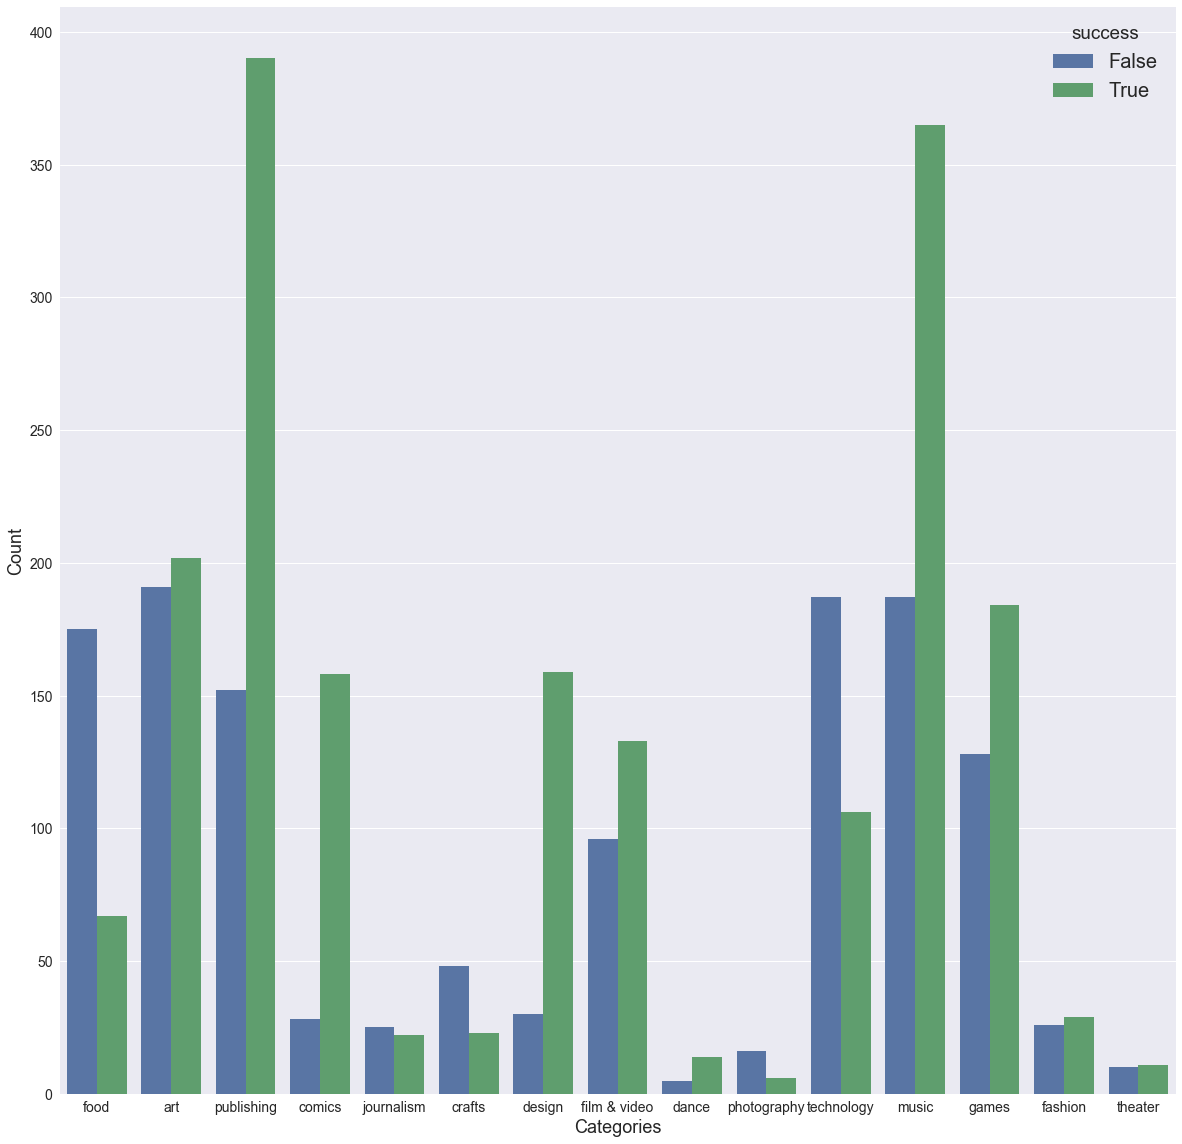

In [8]:
from seaborn import set
plt.rcParams['figure.figsize']=(20,20)
set(font_scale=2)
b=sns.countplot(x='category.slug', hue='success',data=data)
#b.axes.set_title("Title",fontsize=30)
b.set_xlabel("Categories",fontsize=18)
b.set_ylabel("Count",fontsize=18)
b.tick_params(labelsize=14)

Text(0,0.5,'Count')

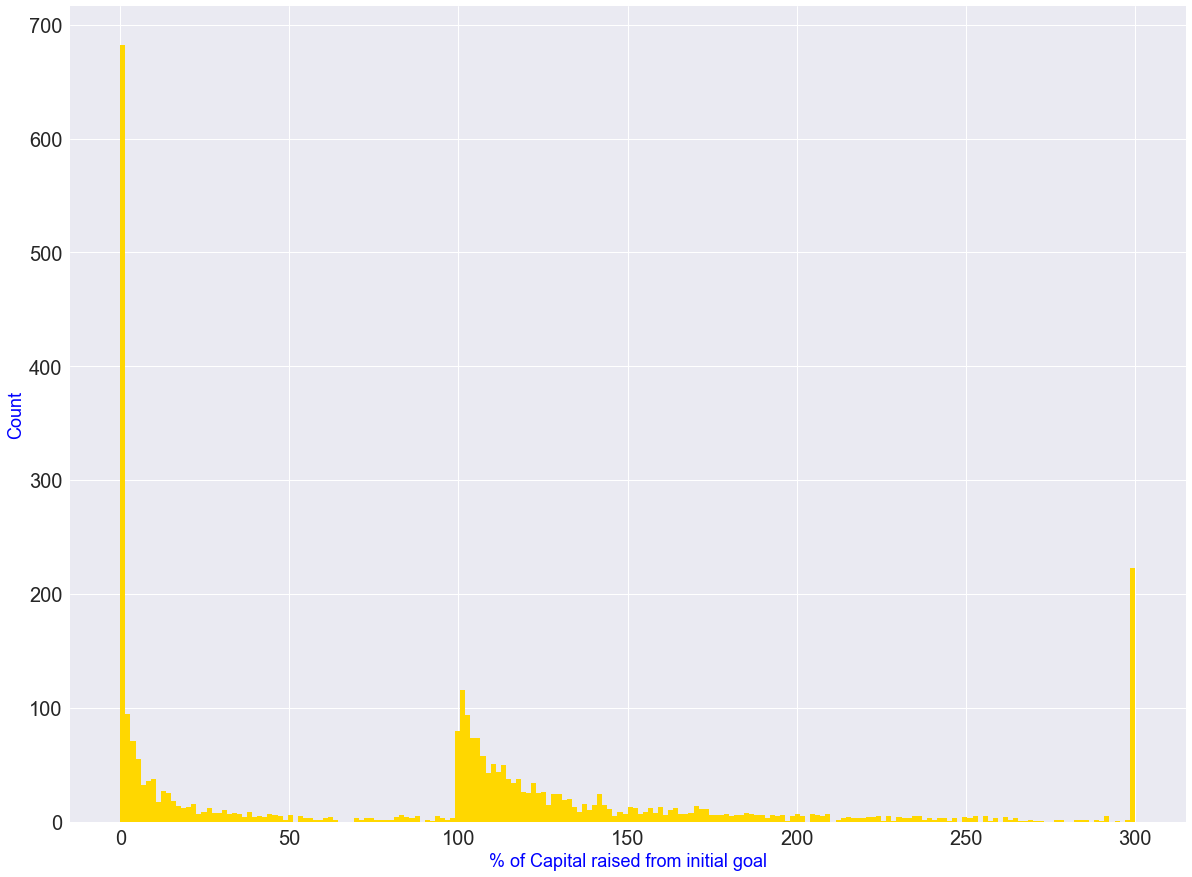

In [9]:
PP=np.clip(data['pledge_perc'], 0, 300)
fig=PP.hist(bins = 200, figsize = (20,15),color='gold')
fig.set_xlabel("% of Capital raised from initial goal",fontsize=18,color='b')
fig.set_ylabel("Count",fontsize=18,color='b')
